**README**: The file only contains the final approach for every task

**Structure:**

Paths to data sets

Imports

Reading in data

**Task 1**:

Preprocessing (needs to be run for all tasks (1-3) first)

Task 1 Model

**Task 2**:

Creating Word Embedding

Task 2 Model

Visualization of the Embedding

**Task 3**:

Task 3 Model without Finetuning

Task 3 Model with Finetuning

In [ ]:
# Paths to data sets

#Change these Path to the paths where the data is located
PATH_to_train = ""
PATH_to_test = ""
PATH_to_dev = ""

In [ ]:
#Install Huging Face Databaseoperations
!pip install transformers
!pip install datasets

In [ ]:
# Imports

#Import Modules
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import gensim.downloader as api
import random
from sklearn.metrics import plot_confusion_matrix
from gensim.models import Word2Vec
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics
from tensorflow.keras.optimizers import Adam

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')


import torch.nn as nn
from transformers.modeling_outputs import TokenClassifierOutput
from torch.utils.data import DataLoader
import torch
from transformers import DataCollatorWithPadding, AdamW, get_scheduler, AutoModelForSequenceClassification, AutoTokenizer, AutoModel, AutoConfig
from datasets import load_metric, Dataset
from torch.optim import AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Reading in data

#Import all data
rawTrainX = pd.read_fwf(PATH_to_train)
rawTestX = pd.read_fwf(PATH_to_test)
rawDevX = pd.read_fwf(PATH_to_dev)
#Removing NaN columns from file reading
rawTrainX.drop(rawTrainX.columns[[1,2]], axis=1, inplace=True)
rawTestX.drop(rawTestX.columns[[1,2,3]], axis=1, inplace=True)
rawDevX.drop(rawDevX.columns[[1,2,3]], axis=1, inplace=True)

TrainX = np.array(rawTrainX)
TestX = np.array(rawTestX)
DevX = np.array(rawDevX)


In [ ]:
# Preprocessing (needs to be run for all tasks (1-3) first)

# Process Input, create X and y arrays, containing the purified
# sentences (lowercase, stopwords removed, punctuation removed, filtered from
# empty lines or plain number lines and all numbers removed), however, no stemming applied
def inputParser(input):
  X = []
  y = []
  for i in tqdm(input):
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(i[0].lower())
    wordsFiltered = []

    for w in words:
        if (w not in stopWords and not w.isdigit()):
          wordsFiltered.append(w)
    wordsFiltered = [''.join(c for c in s if c not in string.punctuation) for s in wordsFiltered]
    wordsFiltered = [s for s in wordsFiltered if s]
    if (wordsFiltered==[]):
      continue
    X.append(" ".join(wordsFiltered[1:]))
    y.append(wordsFiltered[0])
  return np.array(X), np.array(y)

X_train, y_train = inputParser(TrainX)
X_test, y_test = inputParser(TestX)

#Free some space
try:
  del rawTrainX
  del rawTestX
  del TrainX
  del TestX
except: print("")
#X_dev, y_dev = inputParser(DevX)

100%|██████████| 31992/31992 [00:15<00:00, 2005.19it/s]


100%|██████████| 74/74 [3:21:37<00:00, 163.48s/it]


Test f1 score : 0.8101546125227381 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


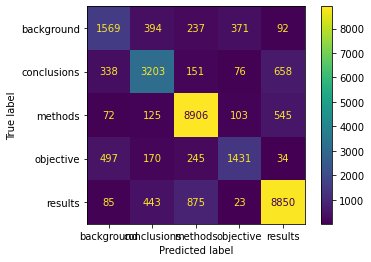

In [ ]:
# TASK 1 MODEL

# Test f1 score : 0.8101546125227381
#Create Batches
batches = []
batchesy = []
batchSize = X_test.shape[0]
numBatches = int(X_train.shape[0]/batchSize)

for i in range(0, numBatches):
    batches.append(X_train[i*batchSize:(i+1)*batchSize])
    batchesy.append(y_train[i*batchSize:(i+1)*batchSize])
batches.append(X_train[batchSize*numBatches:])
batchesy.append(y_train[batchSize*numBatches:])

#Fit vectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)
X_train_vec = vectorizer.transform(batches[0])
X_test_vec = vectorizer.transform(X_test)

#Train model over all batches
clf = MLPClassifier()
clf.partial_fit(X_train_vec, batchesy[0],classes=['background', 'results', 'conclusions', 'methods', 'objective'])
for i in tqdm(range(1, numBatches+1)):
    X_train_vec = vectorizer.transform(batches[i])
    clf.partial_fit(X_train_vec, batchesy[i])

y_pred = clf.predict(X_test_vec)

f1 = f1_score(y_test, y_pred, average="weighted")

print("Test f1 score : %s "% f1)

plot_confusion_matrix(clf, X_test_vec, y_test)
plt.show()




In [ ]:
# Creating Word Embedding

#Delete old variables, to avoid overflow
try:
  del y_pred
  del X_test_vec
  del X_train_vec
  del vectorizer
except: print("")

def computeAverage(X,y,model):
  # Takes a pre-trained word2Vec model and creates a vector per sentence for the
  # input X. In case the word does not occur in the vocabulary, disregard it.
  X_train_embedded = []
  counter = 0
  for i in tqdm(X):
    tempStorage = []
    for j in i:
      try:
        tempStorage.append(model.wv[j])
      except: continue
    if tempStorage != []:
        X_train_embedded.append(np.transpose(tempStorage).mean(axis=1))
    else:
        y = np.delete(y,counter)
        counter = counter - 1
    counter = counter + 1
  X_train_embedded = np.array(X_train_embedded)
  return X_train_embedded, y

def computeEmbedding(X_train,X_test,y_train,y_test):
  # Trains a word2Vec model and brings the input data into the right format.
  X = []
  for i in X_train:
    X.append(i.split())

  X_2 = []
  for i in X_test:
    X_2.append(i.split())

  model = Word2Vec(X,size=150,min_count=7)
  y_train_M2 = y_train
  y_test_M2 = y_test

  X_train_embedded, y_train_M2 = computeAverage(X,y_train_M2,model)
  X_test_embedded, y_test_M2 = computeAverage(X_2,y_test_M2,model)


  return  X_train_embedded, X_test_embedded, y_train_M2, y_test_M2, model

X_train_embedded, X_test_embedded, y_train_M2, y_test_M2, model = computeEmbedding(X_train,X_test,y_train,y_test)


100%|██████████| 29493/29493 [00:01<00:00, 16440.89it/s]


In [ ]:
# TASK 2 MODEL

clf = MLPClassifier(verbose=True)
clf.fit(X_train_embedded, y_train_M2)

y_pred = clf.predict(X_test_embedded)

f1 = f1_score(y_test_M2, y_pred, average="weighted")

print("Test f1 score : %s "% f1)

Iteration 1, loss = 0.59773592
Iteration 2, loss = 0.56452274
Iteration 3, loss = 0.55622995
Iteration 4, loss = 0.55193428
Iteration 5, loss = 0.54926163
Iteration 6, loss = 0.54724557
Iteration 7, loss = 0.54601303
Iteration 8, loss = 0.54478774
Iteration 9, loss = 0.54382985
Iteration 10, loss = 0.54318644
Iteration 11, loss = 0.54241664
Iteration 12, loss = 0.54203242
Iteration 13, loss = 0.54135872
Iteration 14, loss = 0.54103197
Iteration 15, loss = 0.54062906
Iteration 16, loss = 0.54030601
Iteration 17, loss = 0.53994238
Iteration 18, loss = 0.53963232
Iteration 19, loss = 0.53946721
Iteration 20, loss = 0.53913301
Iteration 21, loss = 0.53896990
Iteration 22, loss = 0.53869569
Iteration 23, loss = 0.53861333
Iteration 24, loss = 0.53838941
Iteration 25, loss = 0.53826872
Iteration 26, loss = 0.53815439
Iteration 27, loss = 0.53796917
Iteration 28, loss = 0.53783631
Iteration 29, loss = 0.53774088
Iteration 30, loss = 0.53761958
Iteration 31, loss = 0.53751573
Iteration 32, los

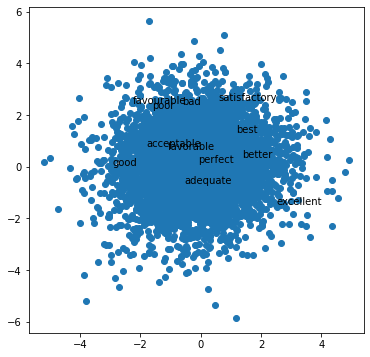

In [ ]:
# Visualization of the Embedding


num_dimensions = 2  # final num dimensions (2D, 3D, etc)

# extract the words & their vectors, as numpy arrays

labels = np.array(model.wv.most_similar('good'))[:,0]
labels = list(labels)
labels.append('good')
labels.append('bad')
vectors = []
for i in model.wv.vocab:
    vectors.append(model.wv[i])

vectors = np.array(vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]

plt.figure(figsize=(6, 6))
plt.scatter(x_vals, y_vals)


for i in range(0,12):
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))


In [ ]:
#TASK 3 Preparing Data for the different models
#Free up some space from previous computations
try:
  del X_train_embedded
  del X_test_embedded
  del y_train_M2
  del y_test_M2
  del model
  del y_pred
  del X_test_vec
  del X_train_vec
  del vectorizer
  del clf
except: print("")

#Convert Test set entries to number entries since this is needed to perform the classification on the models
conversion_dict ={
    'background' :0,
    'conclusions': 1,
    'methods': 2,
    'objective': 3,
    'results': 4
}
converted_y_test = np.zeros(len(y_test))
for i in range(len(y_test)):
   converted_y_test[i]=conversion_dict[y_test[i]]

converted_y_train = np.zeros(len(y_train))
for i in range(len(y_train)):
   converted_y_train[i]=conversion_dict[y_train[i]]

#Create Datasets to later train on
train_dict = {
    "test" : X_train,
    "labels" : converted_y_train.astype(int)
}
train_dataset = Dataset.from_dict(train_dict)

test_dict = {
    "test" : X_test,
    "labels" : converted_y_test.astype(int)
}
test_dataset = Dataset.from_dict(test_dict)

In [ ]:
#Predict on the Dataset without finetuning using the BIO_clinical BERT
#Best Test f1 score : 0.15721864140666747
#Free up some space from previous computations
try:
  del X_train_embedded
  del X_test_embedded
  del y_train_M2
  del y_test_M2
  del model
  del y_pred
  del X_test_vec
  del X_train_vec
  del vectorizer
  del clf
except: print("")
#Tokenize test and training sets for the pretrained BIO_clinical BERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_function(examples):
    return tokenizer(examples["test"], padding="max_length", truncation=True, max_length=24)

tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = tokenized_test_datasets.remove_columns(["test"])
#Sets the getitem return format
tokenized_test_datasets.set_format("torch",columns=["input_ids",  "attention_mask", "labels"])

#Add Classification Header to the BIO_clinical BERT

class CustomModel(nn.Module):
  def __init__(self,checkpoint,num_labels):
    super(CustomModel,self).__init__()
    self.num_labels = num_labels

    #Load Model with given checkpoint and extract its body
    self.model2 = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    #for param in self.model2.parameters():
    #  param.requires_grad = False


    self.dropout = nn.Dropout(0.1)
    #768 is output dimension
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights
    #self.classifier.requires_grad = True

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model2(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)


#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model=CustomModel(checkpoint="emilyalsentzer/Bio_ClinicalBERT",num_labels=5).to(device)

model.eval()

test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

#Predict on test dataset and output f1_score
predictions = []
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = np.append(predictions, (torch.argmax(logits, dim=-1)).detach().cpu().numpy())

f1 = f1_score(converted_y_test.astype(int), predictions, average="weighted")

print("Test f1 score : %s "% f1)

  0%|          | 0/30 [00:00<?, ?ba/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 922/922 [01:43<00:00,  8.92it/s]

Test f1 score : 0.05259342343305513 


In [ ]:
#With Finetuning on the classification header (Bio_ClinicalBERT) needs the previous cell to be run
#Best Test f1 score : 0.6996290116925499
#Best with finetuning on whole set: Test f1 score : 0.8281541239348674


tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def tokenize_function(examples):
    return tokenizer(examples["test"], padding="max_length", truncation=True, max_length=24)

tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
#Sets the getitem return format
tokenized_train_datasets = tokenized_train_datasets.remove_columns(["test"])
tokenized_test_datasets = tokenized_test_datasets.remove_columns(["test"])
tokenized_test_datasets.set_format("torch",columns=["input_ids",  "attention_mask", "labels"])
tokenized_train_datasets.set_format("torch",columns=["input_ids",  "attention_mask", "labels"])


train_dataloader = DataLoader(
    tokenized_train_datasets, shuffle=True, batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)
optimizer = AdamW(model.parameters(), lr=5e-5)


#Train model
model.train()
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

for batch in tqdm(train_dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()


model.eval()

test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

predictions = []

for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = np.append(predictions, (torch.argmax(logits, dim=-1)).detach().cpu().numpy())
    #metric.add_batch(predictions=predictions, references=batch["labels"])

#metric.compute()
f1 = f1_score(converted_y_test.astype(int), predictions, average="weighted")

print("Test f1 score : %s "% f1)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/181 [00:00<?, ?ba/s]

100%|██████████| 922/922 [01:43<00:00,  8.89it/s]

Test f1 score : 0.8281541239348674 
